# Compare CESM2 historic conditions in line with ERA5

- Calculates spatial mean over full domain (removing land points) between 80S to 58S
- On the original ERA5 and CESM2 grids, grid cells not area-weighted (for simplicity, obviously not exactly correct)
- Annual means (easy to regrid to other frequencies)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
from dateutil.relativedelta import relativedelta
import datetime
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range
from nemo_python_git.file_io import find_cesm2_file
from nemo_python_git.atm_calc import wind_curl, wind_divergence

In [2]:
base_dir  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/'
era5_dir  = f'{base_dir}ERA5-forcing/'

In [3]:
ens_strs = ['1011.001', '1031.002', '1051.003', '1071.004', '1091.005', '1111.006', '1131.007', '1151.008', '1171.009', '1191.010']
var_mapping = {'TREFHT':'t2m','FSDS':'msdwswrf','FLDS':'msdwlwrf','QREFHT':'sph2m', 'PRECS':'msr', 'PRECT':'mtpr', 'PSL':'msl', 'wind_speed':'wind_speed'}
#FLDS 1031, 1091, 1151 have some weird daily values; check if that is also true for some of the other files and why

In [4]:
mesh_mask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250715.nc').squeeze()

In [5]:
def viz_timeseries(var_list, freq='1YE', xlim=(None,None)):

    fig, ax = plt.subplots(len(var_list),1, figsize=(11,4*len(var_list)))
    
    for v, var in enumerate(var_list):
        if len(var_list) == 1: 
            axis=ax
        else:
            axis = ax[v]

        # load timeseries
        ds_cesm2 = xr.open_dataset(f'{cesm2_dir}ensemble_mean/{var}_domain_mean_timeseries.nc').resample(time=freq).mean()
        ds_era5  = xr.open_dataset(f'{era5_dir}climatology/{var}_domain_mean_timeseries2.nc').resample(time=freq).mean()
        ds_cesm2_corr = xr.open_dataset(f'{cesm2_dir}ensemble_mean/{var}_ens1011.001_bias_corr_domain_mean_timeseries.nc').resample(time_counter=freq).mean()
        # ds_cesm2_pre  = xr.open_dataset(f'{cesm2_dir}ensemble_mean/{var}_ens1011.001_domain_mean_timeseries.nc').resample(time_counter=freq).mean()
        
        ds_cesm2_sum = 0
        for ens in ens_strs: 
            axis.plot(ds_cesm2.time, ds_cesm2[ens], c='#e1e3e2')
            ds_cesm2_sum = ds_cesm2_sum + ds_cesm2[ens]
        
        # add line for ensemble mean
        axis.plot(ds_cesm2.time, ds_cesm2_sum/len(ens_strs), c='#878787', label='CESM2 raw ensemble mean')
        axis.plot(ds_cesm2.time, ds_cesm2['1011.001'], c='c', linestyle='--', label='CESM2 1011.001')
        # axis.plot(ds_cesm2_pre.time_counter, ds_cesm2_pre[var], c='c', linestyle='--', label='CESM2 1011.001 processed')
        # add line for bias corrected mean
        axis.plot(ds_cesm2_corr.time_counter, ds_cesm2_corr[var], c='c', label='CESM2 1011.001 bias corrected')
    
        axis.plot(ds_era5.time, ds_era5[var_mapping[var]], c='k', label='ERA5')
        axis.legend(frameon=False, loc=2)
        axis.set_title(var)
        axis.set_xlim(xlim[0],xlim[1])

    return fig, ax

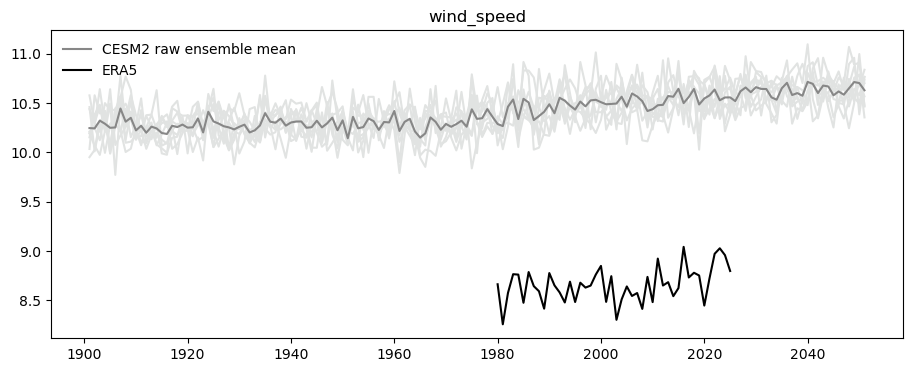

In [33]:
fig, ax = viz_timeseries(['wind_speed'], freq='1YE')

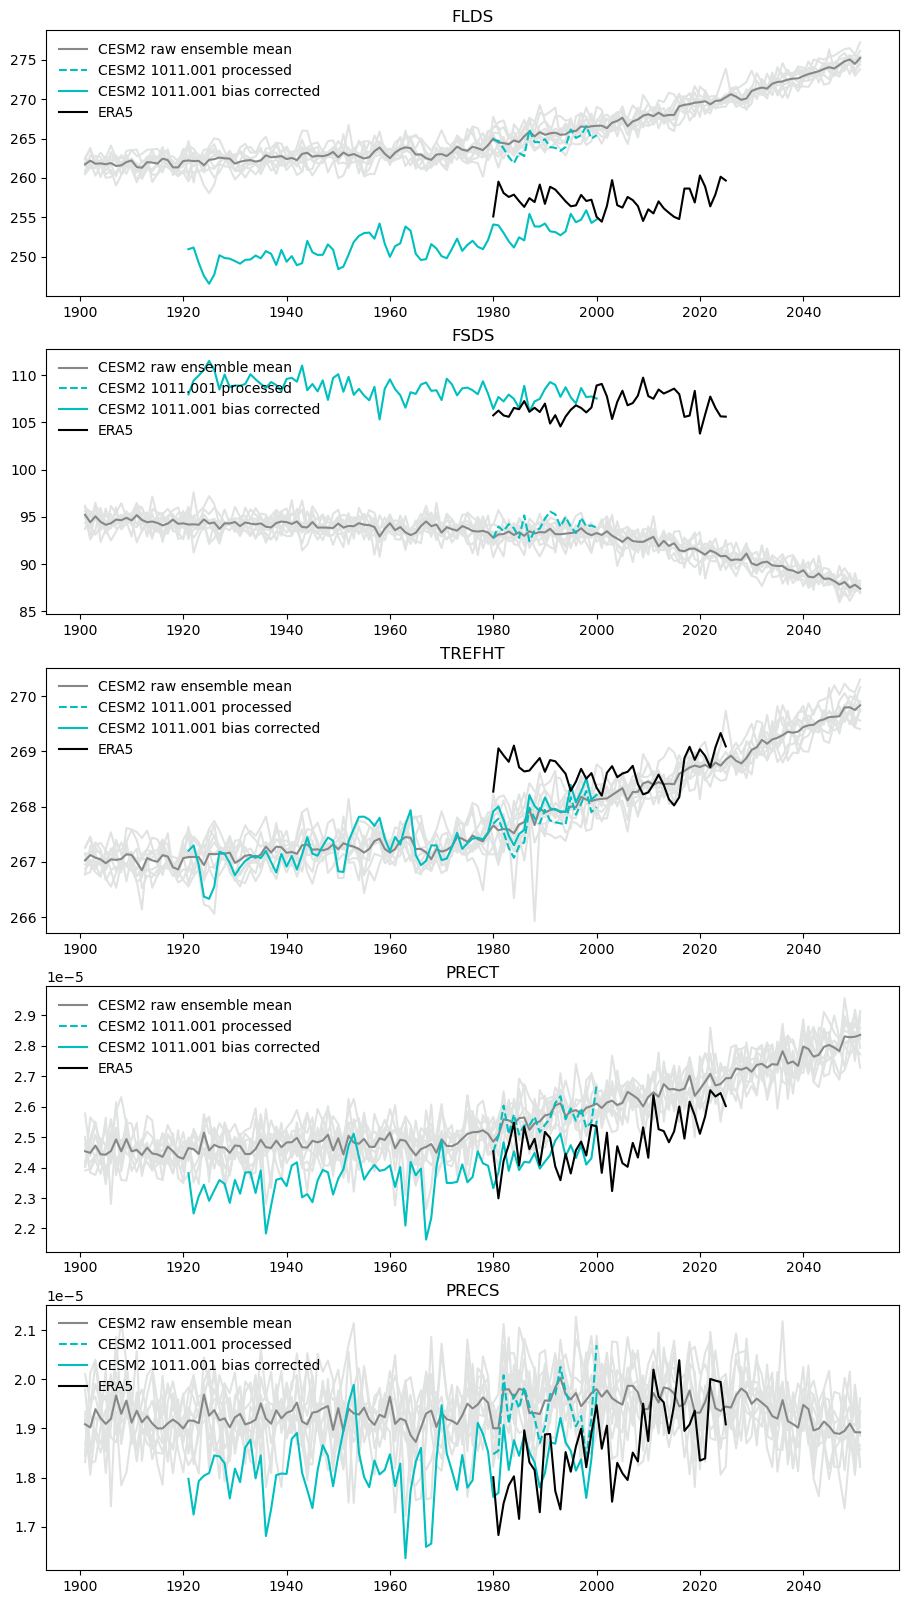

In [7]:
fig, ax = viz_timeseries(['FLDS','FSDS','TREFHT','PRECT','PRECS'], freq='1YE')

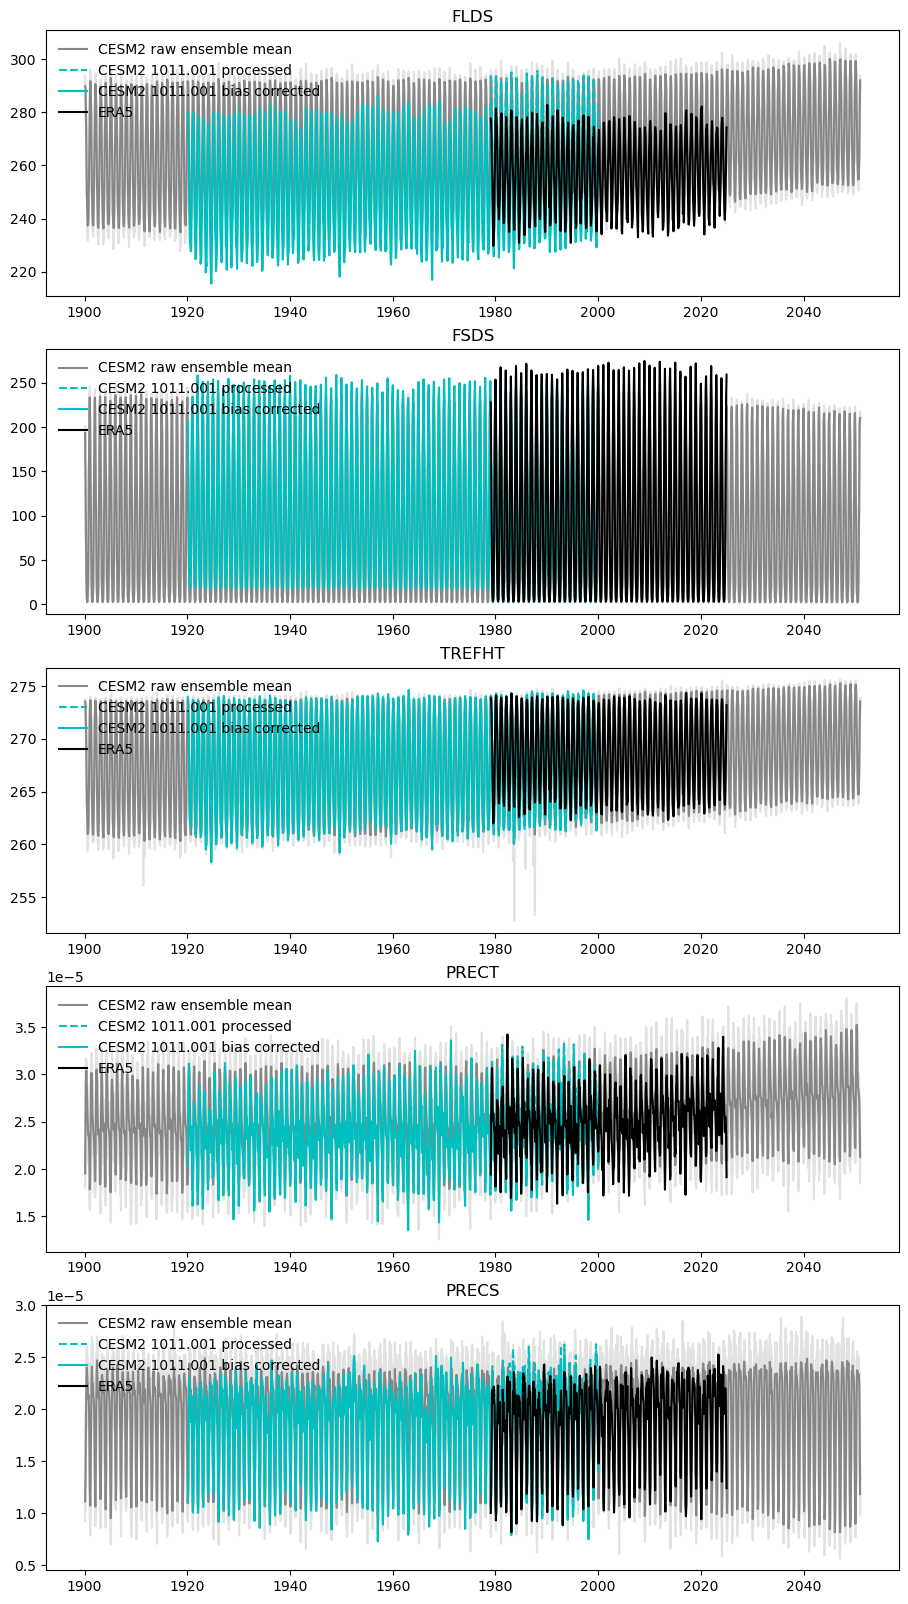

In [8]:
fig, ax = viz_timeseries(['FLDS','FSDS','TREFHT','PRECT','PRECS'], freq='1ME')

## Wind deep dive!

In [5]:
def plot_atm_var(da, year, mask, vmin=None, vmax=None):
    
    fig, ax = plt.subplots(4,3, figsize=(20,15))

    # each panel is a month
    for a, axis in enumerate(ax.ravel()):
        da.isel(month=a).where(mask).plot(ax=axis, cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax)    
        axis.set_title(f'y{year}m{(a+1):02}')
    
        axis.set_xlabel(''); axis.set_ylabel('');
    return

In [54]:
uwind = xr.open_dataset(f'{era5_dir}hourly/processed/u10_y1979.nc').u10.sel(lat=slice(-50,-80))
vwind = xr.open_dataset(f'{era5_dir}hourly/processed/v10_y1979.nc').v10.sel(lat=slice(-50,-80))

era5_mask = xr.open_dataset(f'{era5_dir}climatology/land_sea_mask.nc').isel(time=0).rename({'longitude':'lon','latitude':'lat'})
era5_mask['lon'] = fix_lon_range(era5_mask['lon'])
era5_mask = era5_mask.sortby('lon').isel(lat=slice(None, None, -1)).sel(lat=slice(-80,-50))

In [55]:
ts_zeta = None
ts_div  = None
for month in range(1,13):
    print(month)
    zeta = wind_curl(uwind.isel(time=(uwind.time.dt.month==month)), vwind.isel(time=(vwind.time.dt.month==month)))
    div = wind_divergence(uwind.isel(time=(uwind.time.dt.month==month)), vwind.isel(time=(vwind.time.dt.month==month)))
    zeta_mean = zeta.mean(dim='time')
    div_mean = div.mean(dim='time')

    if ts_zeta is None:
        ts_zeta = zeta_mean
        ts_div  = div_mean
    else:
        ts_zeta = xr.concat([ts_zeta, zeta_mean], dim="month")
        ts_div  = xr.concat([ts_div, div_mean], dim="month")

1
2
3
4
5
6
7
8
9
10
11
12


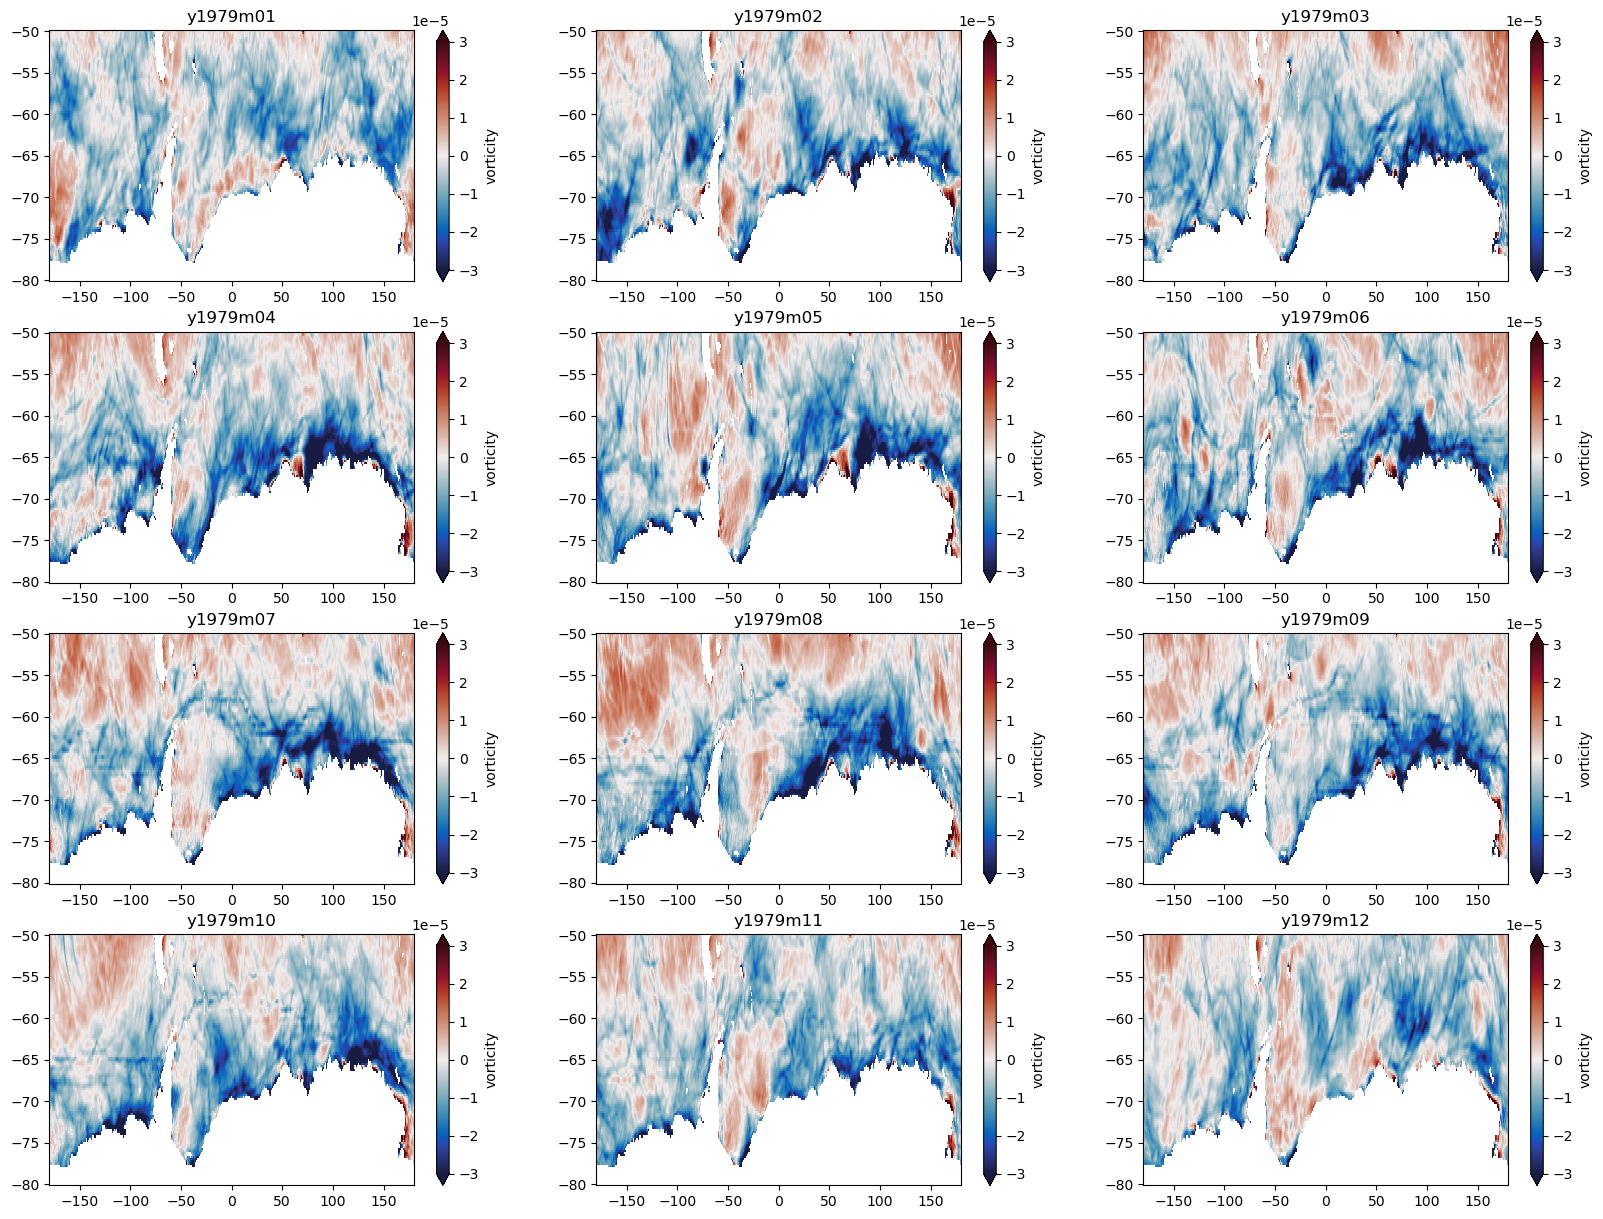

In [35]:
plot_atm_var(ts_zeta, 1979, (era5_mask.lsm==0), vmin=-3e-5, vmax=3e-5)

In [5]:
uwind = xr.open_dataset(f'{cesm2_dir}processed/ens1011.001/CESM2-LE2_ens1011.001_3-hourly_UBOT_y1979.nc').UBOT.sel(lat=slice(-80,-50)).sortby('lon')
vwind = xr.open_dataset(f'{cesm2_dir}processed/ens1011.001/CESM2-LE2_ens1011.001_3-hourly_VBOT_y1979.nc').VBOT.sel(lat=slice(-80,-50)).sortby('lon')

land_mask  = find_cesm2_file('LE2', 'LANDFRAC', 'atm', 'monthly', '1011.001', 1979)
cesm2_mask = xr.open_dataset(land_mask).LANDFRAC.isel(time=0)
cesm2_mask['lon'] = fix_lon_range(cesm2_mask['lon'])
cesm2_mask = cesm2_mask.sortby('lon','lat').sel(lat=slice(-80,-50))

In [ ]:
ts_zeta_cesm2 = None
for month in range(1,13):
    zeta = curl_spherical(uwind.isel(time=(uwind.time.dt.month==month)), vwind.isel(time=(vwind.time.dt.month==month)))
    zeta_mean = zeta.mean(dim='time')

    if ts_zeta_cesm2 is None:
        ts_zeta_cesm2 = zeta_mean
    else:
        ts_zeta_cesm2 = xr.concat([ts_zeta_cesm2, zeta_mean], dim="month")

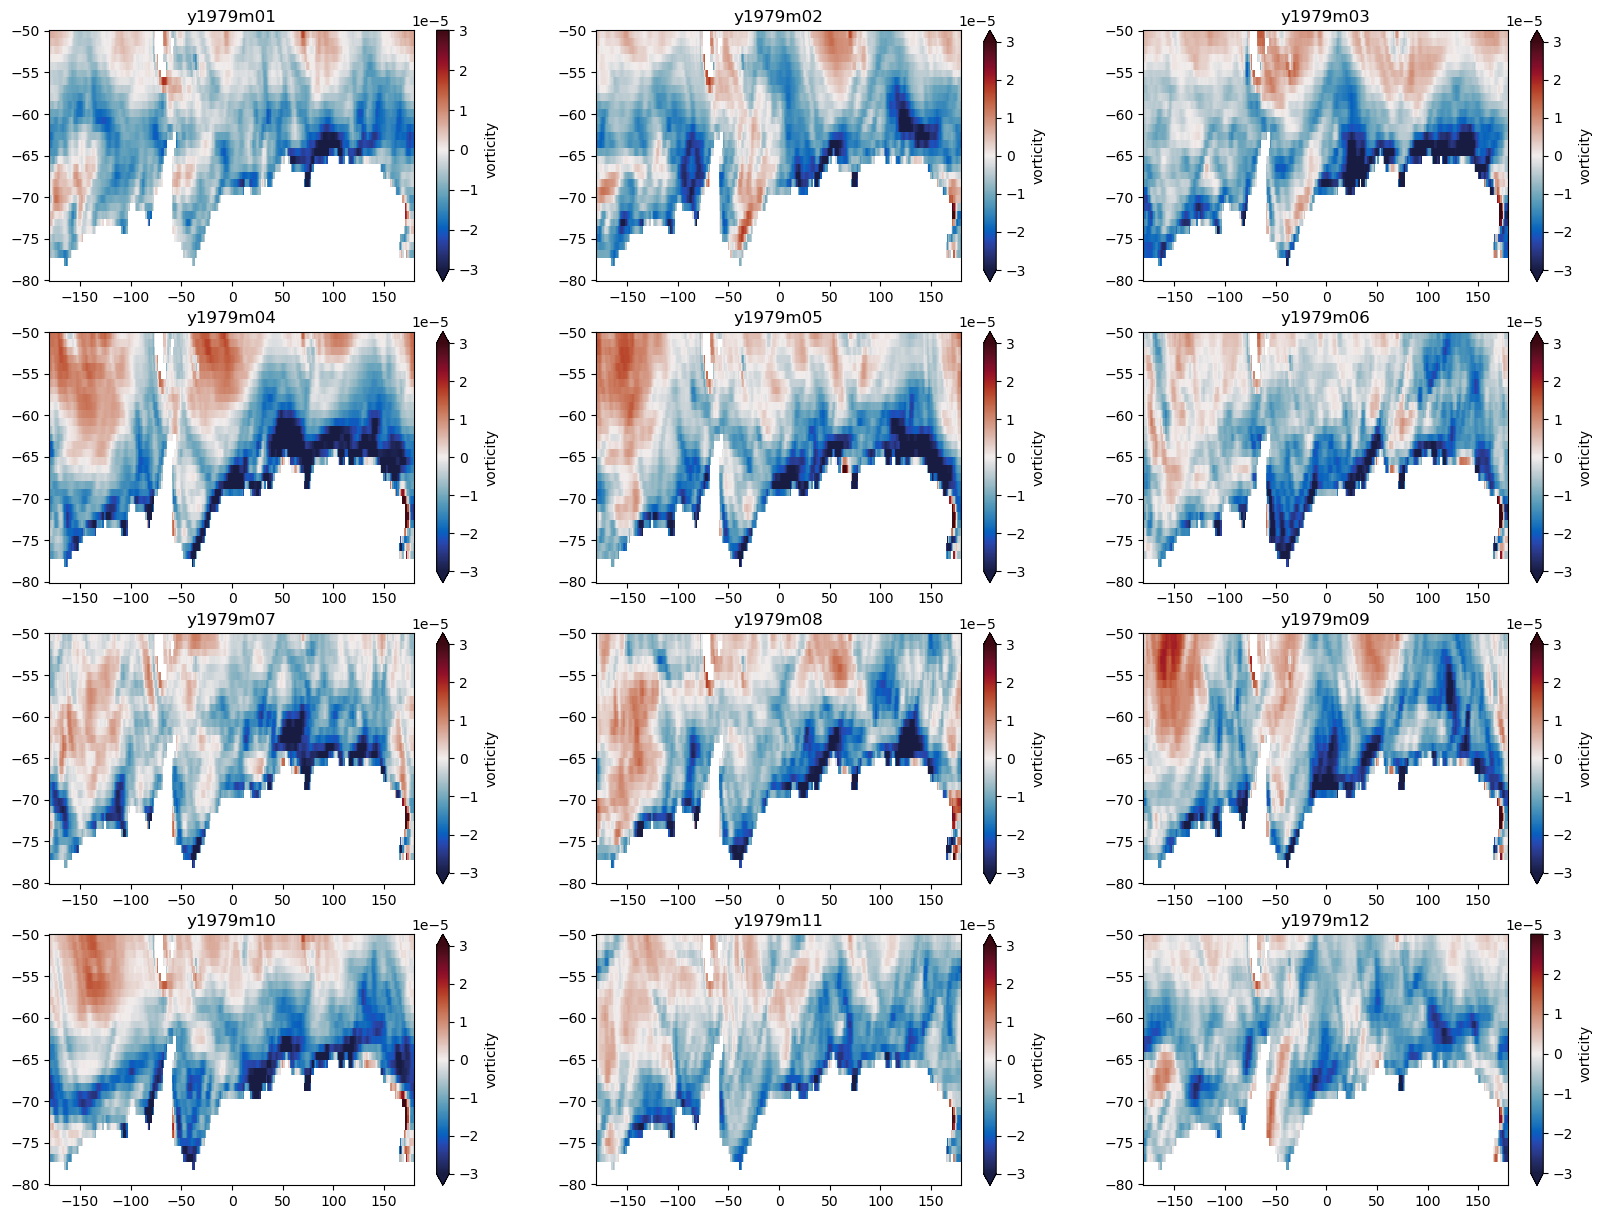

In [46]:
plot_atm_var(ts_zeta_cesm2, 1979, (cesm2_mask==0), vmin=-3e-5, vmax=3e-5)

In [6]:
from tqdm import tqdm

In [7]:
base_dir  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/'
latslice  = slice(-90,-50)
# ens='1051.003'

# ens_strs = ['1011.001','1031.002','1051.003','1071.004','1091.005','1111.006','1131.007','1151.008','1171.009','1191.010'] + \
#             [f'1231.0{i:02}' for i in range(11,16)] + [f'1251.0{i:02}' for i in range(11,16)] + [f'1281.0{i:02}' for i in range(11,16)] + \
#             [f'1301.0{i:02}' for i in range(11,16)]
ens_strs =  [f'1251.0{i:02}' for i in range(12,16)] + [f'1281.0{i:02}' for i in range(11,16)] + \
            [f'1301.0{i:02}' for i in range(11,16)]

for ens in ens_strs:
    ds_curl_ts = None
    ds_div_ts  = None
    print(ens)
    for year in tqdm(range(1979,2025)):
        uwind = xr.open_dataset(f'{cesm2_dir}processed/ens{ens}/CESM2-LE2_ens{ens}_3-hourly_UBOT_y{year}.nc').UBOT.sel(lat=latslice).sortby('lon')
        vwind = xr.open_dataset(f'{cesm2_dir}processed/ens{ens}/CESM2-LE2_ens{ens}_3-hourly_VBOT_y{year}.nc').VBOT.sel(lat=latslice).sortby('lon')
    
        for month in range(1,13):
            zeta      = wind_curl(uwind.isel(time=(uwind.time.dt.month==month)), vwind.isel(time=(vwind.time.dt.month==month)))
            zeta_mean = zeta.mean(dim='time')
            div       = wind_divergence(uwind.isel(time=(uwind.time.dt.month==month)), vwind.isel(time=(vwind.time.dt.month==month)))
            div_mean  = div.mean(dim='time')
    
            if ds_curl_ts is None:
                ds_curl_ts = zeta_mean
                ds_div_ts  = div_mean
            else:
                ds_curl_ts = xr.concat([ds_curl_ts, zeta_mean], dim="time")
                ds_div_ts  = xr.concat([ds_div_ts, div_mean], dim="time")
    
    ds_time = [datetime.datetime(1979, 1, 1) + relativedelta(months=dt) for dt in range(0,len(range(1979,2025))*12)]
    ds_curl_ts = ds_curl_ts.assign_coords({'time':ds_time})
    ds_div_ts  = ds_div_ts.assign_coords({'time':ds_time})
    
    ds_curl_ts.to_dataset().to_netcdf(f'{cesm2_dir}ensemble_mean/wind_curl_ens{ens}_1979-2024.nc')
    ds_div_ts.to_dataset().to_netcdf(f'{cesm2_dir}ensemble_mean/wind_divergence_ens{ens}_1979-2024.nc')

1251.012


100%|██████████| 46/46 [09:02<00:00, 11.79s/it]


1251.013


100%|██████████| 46/46 [09:04<00:00, 11.84s/it]


1251.014


100%|██████████| 46/46 [09:00<00:00, 11.75s/it]


1251.015


100%|██████████| 46/46 [09:00<00:00, 11.76s/it]


1281.011


100%|██████████| 46/46 [09:49<00:00, 12.82s/it]


1281.012


100%|██████████| 46/46 [09:00<00:00, 11.75s/it]


1281.013


100%|██████████| 46/46 [09:14<00:00, 12.05s/it]


1281.014


100%|██████████| 46/46 [09:14<00:00, 12.06s/it]


1281.015


100%|██████████| 46/46 [08:57<00:00, 11.69s/it]


1301.011


100%|██████████| 46/46 [09:30<00:00, 12.40s/it]


1301.012


100%|██████████| 46/46 [10:34<00:00, 13.80s/it]


1301.013


100%|██████████| 46/46 [09:49<00:00, 12.81s/it]


1301.014


100%|██████████| 46/46 [09:12<00:00, 12.02s/it]


1301.015


100%|██████████| 46/46 [09:34<00:00, 12.49s/it]


In [57]:
ensemble_curl = xr.Dataset()
ensemble_div  = xr.Dataset()
for ens in ens_strs:
    ds_curl = xr.open_dataset(f'{cesm2_dir}ensemble_mean/wind_curl_ens{ens}_1979-2024.nc')
    ds_div  = xr.open_dataset(f'{cesm2_dir}ensemble_mean/wind_divergence_ens{ens}_1979-2024.nc')

    ensemble_curl[f'{ens}'] = ds_curl.vorticity.groupby('time.month').mean()
    ensemble_div[f'{ens}']  = ds_div.divergence.groupby('time.month').mean()